In [1]:
%cd C:/Users/Mathieu/Desktop/Projets/Benter

C:\Users\Mathieu\Desktop\Projets\Benter


In [4]:
%matplotlib inline
import collections
import functools

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
from tqdm import tqdm


from utils import import_data
from machine_learning.logistic_regression import LogisticRegressionModel
from constants import PMU_BETTINGS

from matplotlib import style
style.use('ggplot')

In [5]:
# TODO Go through validation dataset in the same order

In [7]:
n_horses =10

betting_name = "E_SIMPLE_GAGNANT"
SOURCE='PMU'

initial_capital = 100
track_take = [betting for betting in PMU_BETTINGS if betting.name == betting_name][0][1]

In [8]:
x_race, y_race, odds = import_data.get_races_per_horse_number(n_horses=n_horses, on_split='val', y_format = 'rank', source='PMU', remove_nan_odds=True)
#odds=odds*np.sum(1/odds, axis=1, keepdims=True) # Rectification to be consistent (not needed for PMU)

sequential_sgd_regression = LogisticRegressionModel.load_model(trainable=False)
y_hat=sequential_sgd_regression.predict(x=x_race)

expected_returns =(y_hat*odds*(1-track_take))


C:\Users\Mathieu\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:1: DtypeWarning: Columns (50,51,52,53) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


Instructions for updating:
Colocations handled automatically by placer.


AttributeError: 'LogisticRegressionModel' object has no attribute 'predict'

In [ ]:
# Model error analysis to find winning horse
proba_winner =np.max(np.where(y_race==1, y_hat, np.zeros_like(y_hat)), axis=1)
N=100
moving_average_proba_winner = np.convolve(proba_winner, np.ones((N,))/N, mode='valid')

ax=sns.scatterplot(y=proba_winner, x=np.arange(proba_winner.shape[0]))
ax=sns.lineplot(y=moving_average_proba_winner, x=np.arange(moving_average_proba_winner.shape[0]), ax=ax, color='k');
plt.ylim()
plt.show()

In [ ]:
y_race.shape

In [ ]:
y_hat.shape

In [ ]:
expected_returns.shape

In [16]:
# proportial to expected return 

capital_fraction = 0.01
positives_returns= np.where(expected_returns>1, expected_returns, np.zeros_like(expected_returns))
bettings = positives_returns/np.sum(positives_returns, axis=1, keepdims=True)
bettings[np.isnan(bettings)]=0
bettings=bettings*capital_fraction

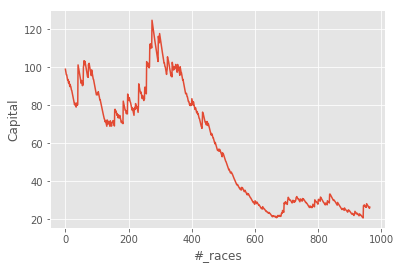

End capital: 26.49, growth rate: -0.14%, exponential growth rate: -0.14%


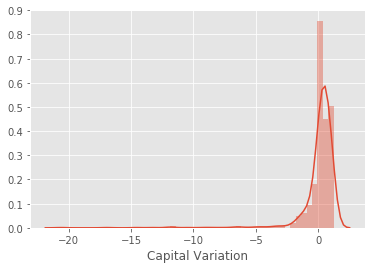

Capital is never null!


In [17]:
sum_proba_races = np.sum(bettings, axis=1)
assert np.all(0<=sum_proba_races) and (np.all(sum_proba_races<=1) or np.all(np.isclose(sum_proba_races, 1.0)))
relative_returns = np.where(y_race==1, bettings*odds*(1-track_take), np.zeros_like(bettings)).sum(axis=1)- np.sum(bettings, axis=1)

capital = np.multiply.accumulate(np.insert(1.0+relative_returns, 0, initial_capital))
data = pd.DataFrame({'Capital Variation':capital[:-1] - capital[1:], "Capital":capital[1:], "Relative returns": relative_returns})
data['#_races']=data.index.to_series()
ax=sns.lineplot(data=data, x="#_races",y="Capital")
plt.show()

exp_growth_rate = np.log(capital[-1]/capital[0])/relative_returns.shape[0]
growth_rate = np.power(capital[-1]/capital[0], 1/relative_returns.shape[0])-1
print(f"End capital: {capital[-1]:.2f}, growth rate: {growth_rate:.2%}, exponential growth rate: {exp_growth_rate:.2%}")
sns.distplot(data['Capital Variation'])
plt.show()
zero_capital_indices =np.argwhere(capital==0.0)
if zero_capital_indices.size==0:
    print('Capital is never null!')
else:
    print(f"No more capital after race n°{zero_capital_indices[0,0]} (index {zero_capital_indices[0,0]-1})")

In [18]:
# on the best expected return 
capital_fraction = 0.01
bettings = np.where(expected_returns==np.max(expected_returns, axis=1, keepdims=True), capital_fraction*np.ones_like(expected_returns), np.zeros_like(expected_returns))


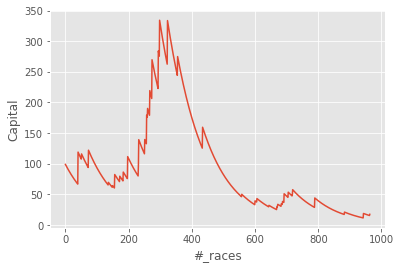

End capital: 17.58, growth rate: -0.18%, exponential growth rate: -0.18%


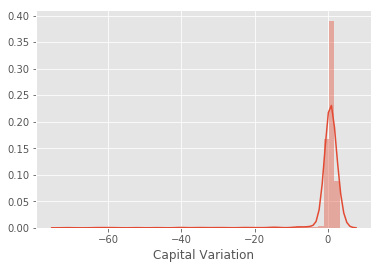

Capital is never null!


In [19]:
sum_proba_races = np.sum(bettings, axis=1)
assert np.all(0<=sum_proba_races) and (np.all(sum_proba_races<=1) or np.all(np.isclose(sum_proba_races, 1.0)))
relative_returns = np.where(y_race==1, bettings*odds*(1-track_take), np.zeros_like(bettings)).sum(axis=1)- np.sum(bettings, axis=1)

capital = np.multiply.accumulate(np.insert(1.0+relative_returns, 0, initial_capital))
data = pd.DataFrame({'Capital Variation':capital[:-1] - capital[1:], "Capital":capital[1:], "Relative returns": relative_returns})
data['#_races']=data.index.to_series()
ax=sns.lineplot(data=data, x="#_races",y="Capital")
plt.show()

exp_growth_rate = np.log(capital[-1]/capital[0])/relative_returns.shape[0]
growth_rate = np.power(capital[-1]/capital[0], 1/relative_returns.shape[0])-1
print(f"End capital: {capital[-1]:.2f}, growth rate: {growth_rate:.2%}, exponential growth rate: {exp_growth_rate:.2%}")
sns.distplot(data['Capital Variation'])
plt.show()
zero_capital_indices =np.argwhere(capital==0.0)
if zero_capital_indices.size==0:
    print('Capital is never null!')
else:
    print(f"No more capital after race n°{zero_capital_indices[0,0]} (index {zero_capital_indices[0,0]-1})")

In [20]:
# Optimal with Kelly criterion

def compute_optimal_betting(race_proba, race_odds):
    
    race_expected_return = (race_proba*race_odds*(1-track_take))
    S=[]
    k=1
    R_S =1
    order_index = (-race_expected_return).argsort()

    for kth in order_index:
        if race_expected_return[kth]<R_S:
            break
        S.append(kth)
        R_S = 1 - np.sum(race_proba[S])/(1-np.sum(1/(race_odds*(1-track_take))))

    if not S:
        return np.zeros_like(race_proba)

    race_f=np.clip((race_expected_return - R_S)/(1-track_take)/race_odds, a_min=0, a_max=None)
    return race_f

# TODO to test

bettings = np.array([compute_optimal_betting(race_proba, race_odds ) for race_proba, race_odds, race_expected_return in zip(y_hat,odds, expected_returns)])


In [21]:
# Proportional to winning proba
capital_fraction = 0.01
bettings = y_hat*capital_fraction

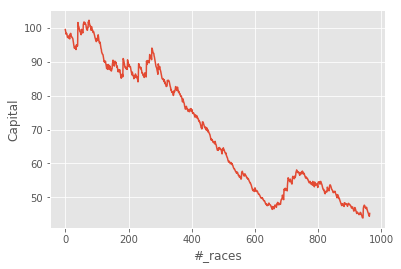

End capital: 45.26, growth rate: -0.08%, exponential growth rate: -0.08%


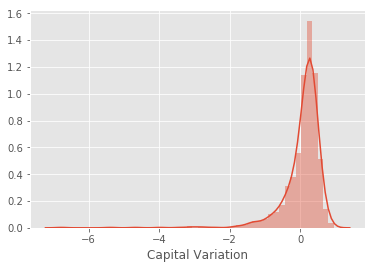

Capital is never null!


In [22]:
sum_proba_races = np.sum(bettings, axis=1)
assert np.all(0<=sum_proba_races) and (np.all(sum_proba_races<=1) or np.all(np.isclose(sum_proba_races, 1.0)))
relative_returns = np.where(y_race==1, bettings*odds*(1-track_take), np.zeros_like(bettings)).sum(axis=1)- np.sum(bettings, axis=1)

capital = np.multiply.accumulate(np.insert(1.0+relative_returns, 0, initial_capital))
data = pd.DataFrame({'Capital Variation':capital[:-1] - capital[1:], "Capital":capital[1:], "Relative returns": relative_returns})
data['#_races']=data.index.to_series()
ax=sns.lineplot(data=data, x="#_races",y="Capital")
plt.show()

exp_growth_rate = np.log(capital[-1]/capital[0])/relative_returns.shape[0]
growth_rate = np.power(capital[-1]/capital[0], 1/relative_returns.shape[0])-1
print(f"End capital: {capital[-1]:.2f}, growth rate: {growth_rate:.2%}, exponential growth rate: {exp_growth_rate:.2%}")
sns.distplot(data['Capital Variation'])
plt.show()
zero_capital_indices =np.argwhere(capital==0.0)
if zero_capital_indices.size==0:
    print('Capital is never null!')
else:
    print(f"No more capital after race n°{zero_capital_indices[0,0]} (index {zero_capital_indices[0,0]-1})")

In [23]:
# Best winning proba
capital_fraction = 0.01
bettings = np.where(y_hat==np.max(y_hat, axis=1, keepdims=True), np.ones_like(y_hat), np.zeros_like(y_hat))
bettings = bettings/np.sum(bettings, axis=1, keepdims=True)
bettings=bettings*capital_fraction

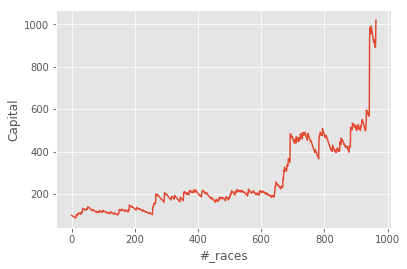

End capital: 1019.05, growth rate: 0.24%, exponential growth rate: 0.24%


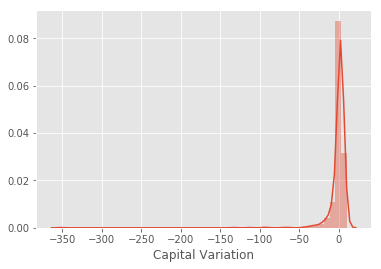

Capital is never null!


In [24]:
sum_proba_races = np.sum(bettings, axis=1)
assert np.all(0<=sum_proba_races) and (np.all(sum_proba_races<=1) or np.all(np.isclose(sum_proba_races, 1.0)))
relative_returns = np.where(y_race==1, bettings*odds*(1-track_take), np.zeros_like(bettings)).sum(axis=1)- np.sum(bettings, axis=1)

capital = np.multiply.accumulate(np.insert(1.0+relative_returns, 0, initial_capital))
data = pd.DataFrame({'Capital Variation':capital[:-1] - capital[1:], "Capital":capital[1:], "Relative returns": relative_returns})
data['#_races']=data.index.to_series()
ax=sns.lineplot(data=data, x="#_races",y="Capital")
plt.show()

exp_growth_rate = np.log(capital[-1]/capital[0])/relative_returns.shape[0]
growth_rate = np.power(capital[-1]/capital[0], 1/relative_returns.shape[0])-1
print(f"End capital: {capital[-1]:.2f}, growth rate: {growth_rate:.2%}, exponential growth rate: {exp_growth_rate:.2%}")
sns.distplot(data['Capital Variation'])
plt.show()
zero_capital_indices =np.argwhere(capital==0.0)
if zero_capital_indices.size==0:
    print('Capital is never null!')
else:
    print(f"No more capital after race n°{zero_capital_indices[0,0]} (index {zero_capital_indices[0,0]-1})")

In [25]:
# Random on 1 horse

capital_fraction = 0.01
np.random.seed(42)
bettings=np.random.rand(*y_race.shape)
bettings=bettings==np.max(bettings, axis=1, keepdims=True)
bettings =bettings*capital_fraction

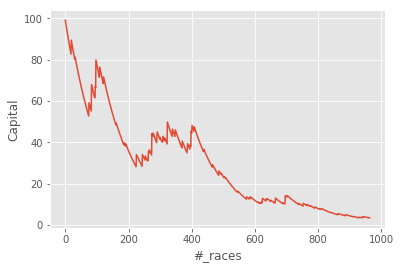

End capital: 3.38, growth rate: -0.35%, exponential growth rate: -0.35%


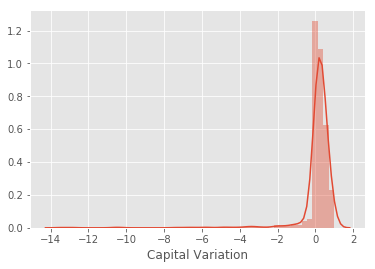

Capital is never null!


In [26]:
sum_proba_races = np.sum(bettings, axis=1)
assert np.all(0<=sum_proba_races) and (np.all(sum_proba_races<=1) or np.all(np.isclose(sum_proba_races, 1.0)))
relative_returns = np.where(y_race==1, bettings*odds*(1-track_take), np.zeros_like(bettings)).sum(axis=1)- np.sum(bettings, axis=1)

capital = np.multiply.accumulate(np.insert(1.0+relative_returns, 0, initial_capital))
data = pd.DataFrame({'Capital Variation':capital[:-1] - capital[1:], "Capital":capital[1:], "Relative returns": relative_returns})
data['#_races']=data.index.to_series()
ax=sns.lineplot(data=data, x="#_races",y="Capital")
plt.show()

exp_growth_rate = np.log(capital[-1]/capital[0])/relative_returns.shape[0]
growth_rate = np.power(capital[-1]/capital[0], 1/relative_returns.shape[0])-1
print(f"End capital: {capital[-1]:.2f}, growth rate: {growth_rate:.2%}, exponential growth rate: {exp_growth_rate:.2%}")
sns.distplot(data['Capital Variation'])
plt.show()
zero_capital_indices =np.argwhere(capital==0.0)
if zero_capital_indices.size==0:
    print('Capital is never null!')
else:
    print(f"No more capital after race n°{zero_capital_indices[0,0]} (index {zero_capital_indices[0,0]-1})")

In [27]:
# Random on all horses
capital_fraction = 0.05
bettings =np.ones_like(y_race)/y_race.shape[1]
bettings = bettings*capital_fraction

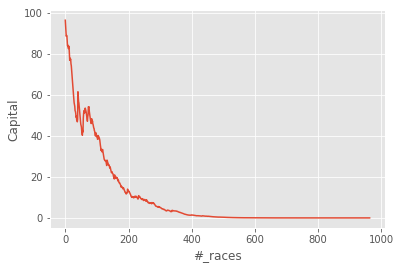

End capital: 0.00, growth rate: -1.14%, exponential growth rate: -1.15%


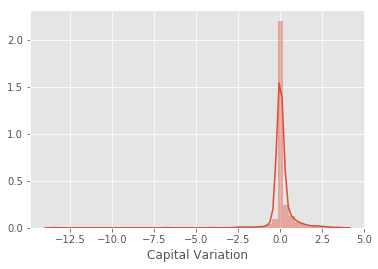

Capital is never null!


In [28]:
sum_proba_races = np.sum(bettings, axis=1)
assert np.all(0<=sum_proba_races) and (np.all(sum_proba_races<=1) or np.all(np.isclose(sum_proba_races, 1.0)))
relative_returns = np.where(y_race==1, bettings*odds*(1-track_take), np.zeros_like(bettings)).sum(axis=1)- np.sum(bettings, axis=1)

capital = np.multiply.accumulate(np.insert(1.0+relative_returns, 0, initial_capital))
data = pd.DataFrame({'Capital Variation':capital[:-1] - capital[1:], "Capital":capital[1:], "Relative returns": relative_returns})
data['#_races']=data.index.to_series()
ax=sns.lineplot(data=data, x="#_races",y="Capital")
plt.show()

exp_growth_rate = np.log(capital[-1]/capital[0])/relative_returns.shape[0]
growth_rate = np.power(capital[-1]/capital[0], 1/relative_returns.shape[0])-1
print(f"End capital: {capital[-1]:.2f}, growth rate: {growth_rate:.2%}, exponential growth rate: {exp_growth_rate:.2%}")
sns.distplot(data['Capital Variation'])
plt.show()
zero_capital_indices =np.argwhere(capital==0.0)
if zero_capital_indices.size==0:
    print('Capital is never null!')
else:
    print(f"No more capital after race n°{zero_capital_indices[0,0]} (index {zero_capital_indices[0,0]-1})")

In [29]:
# Follow most risky odds
capital_fraction =0.01
bettings = np.where(odds==np.max(odds, axis=1, keepdims=True), np.ones_like(y_race), np.zeros_like(y_race))
bettings=bettings/np.sum(bettings, axis=1, keepdims=True)
bettings =bettings*capital_fraction

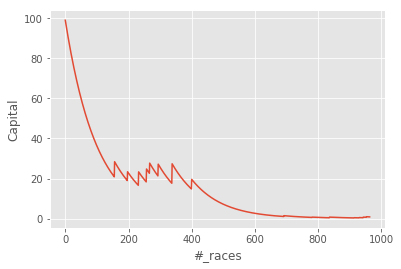

End capital: 0.85, growth rate: -0.49%, exponential growth rate: -0.49%


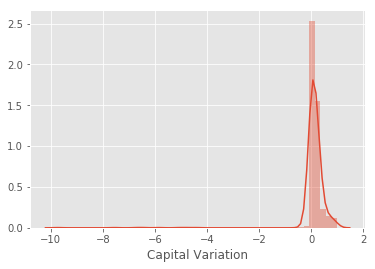

Capital is never null!


In [30]:
sum_proba_races = np.sum(bettings, axis=1)
assert np.all(0<=sum_proba_races) and (np.all(sum_proba_races<=1) or np.all(np.isclose(sum_proba_races, 1.0)))
relative_returns = np.where(y_race==1, bettings*odds*(1-track_take), np.zeros_like(bettings)).sum(axis=1)- np.sum(bettings, axis=1)

capital = np.multiply.accumulate(np.insert(1.0+relative_returns, 0, initial_capital))
data = pd.DataFrame({'Capital Variation':capital[:-1] - capital[1:], "Capital":capital[1:], "Relative returns": relative_returns})
data['#_races']=data.index.to_series()
ax=sns.lineplot(data=data, x="#_races",y="Capital")
plt.show()

exp_growth_rate = np.log(capital[-1]/capital[0])/relative_returns.shape[0]
growth_rate = np.power(capital[-1]/capital[0], 1/relative_returns.shape[0])-1
print(f"End capital: {capital[-1]:.2f}, growth rate: {growth_rate:.2%}, exponential growth rate: {exp_growth_rate:.2%}")
sns.distplot(data['Capital Variation'])
plt.show()
zero_capital_indices =np.argwhere(capital==0.0)
if zero_capital_indices.size==0:
    print('Capital is never null!')
else:
    print(f"No more capital after race n°{zero_capital_indices[0,0]} (index {zero_capital_indices[0,0]-1})")

In [31]:
# Follow least risky odds
capital_fraction =0.01
bettings = np.where(odds==np.min(odds, axis=1, keepdims=True), np.ones_like(y_race), np.zeros_like(y_race))
bettings=bettings/np.sum(bettings, axis=1, keepdims=True)
bettings =bettings*capital_fraction

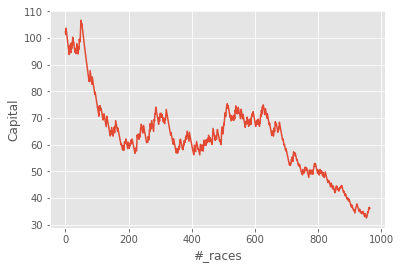

End capital: 36.12, growth rate: -0.11%, exponential growth rate: -0.11%


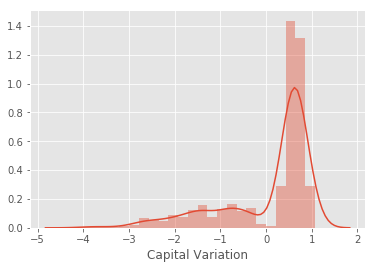

Capital is never null!


In [32]:
sum_proba_races = np.sum(bettings, axis=1)
assert np.all(0<=sum_proba_races) and (np.all(sum_proba_races<=1) or np.all(np.isclose(sum_proba_races, 1.0)))
relative_returns = np.where(y_race==1, bettings*odds*(1-track_take), np.zeros_like(bettings)).sum(axis=1)- np.sum(bettings, axis=1)

capital = np.multiply.accumulate(np.insert(1.0+relative_returns, 0, initial_capital))
data = pd.DataFrame({'Capital Variation':capital[:-1] - capital[1:], "Capital":capital[1:], "Relative returns": relative_returns})
data['#_races']=data.index.to_series()
ax=sns.lineplot(data=data, x="#_races",y="Capital")
plt.show()

exp_growth_rate = np.log(capital[-1]/capital[0])/relative_returns.shape[0]
growth_rate = np.power(capital[-1]/capital[0], 1/relative_returns.shape[0])-1
print(f"End capital: {capital[-1]:.2f}, growth rate: {growth_rate:.2%}, exponential growth rate: {exp_growth_rate:.2%}")
sns.distplot(data['Capital Variation'])
plt.show()
zero_capital_indices =np.argwhere(capital==0.0)
if zero_capital_indices.size==0:
    print('Capital is never null!')
else:
    print(f"No more capital after race n°{zero_capital_indices[0,0]} (index {zero_capital_indices[0,0]-1})")

In [33]:
# Proportional to odds
capital_fraction =0.05
bettings = odds/np.sum(odds, axis=1, keepdims=True)
bettings = bettings*capital_fraction

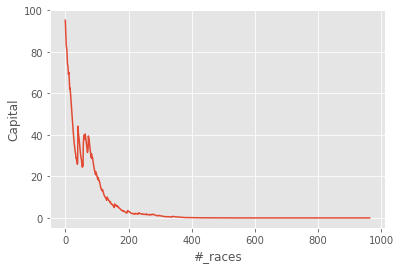

End capital: 0.00, growth rate: -1.83%, exponential growth rate: -1.85%


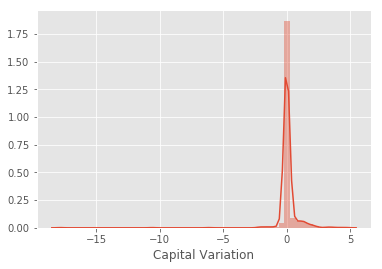

Capital is never null!


In [34]:
sum_proba_races = np.sum(bettings, axis=1)
assert np.all(0<=sum_proba_races) and (np.all(sum_proba_races<=1) or np.all(np.isclose(sum_proba_races, 1.0)))
relative_returns = np.where(y_race==1, bettings*odds*(1-track_take), np.zeros_like(bettings)).sum(axis=1)- np.sum(bettings, axis=1)

capital = np.multiply.accumulate(np.insert(1.0+relative_returns, 0, initial_capital))
data = pd.DataFrame({'Capital Variation':capital[:-1] - capital[1:], "Capital":capital[1:], "Relative returns": relative_returns})
data['#_races']=data.index.to_series()
ax=sns.lineplot(data=data, x="#_races",y="Capital")
plt.show()

exp_growth_rate = np.log(capital[-1]/capital[0])/relative_returns.shape[0]
growth_rate = np.power(capital[-1]/capital[0], 1/relative_returns.shape[0])-1
print(f"End capital: {capital[-1]:.2f}, growth rate: {growth_rate:.2%}, exponential growth rate: {exp_growth_rate:.2%}")
sns.distplot(data['Capital Variation'])
plt.show()
zero_capital_indices =np.argwhere(capital==0.0)
if zero_capital_indices.size==0:
    print('Capital is never null!')
else:
    print(f"No more capital after race n°{zero_capital_indices[0,0]} (index {zero_capital_indices[0,0]-1})")

In [35]:
# Proportional to pari-mutual proba (1/odds)

capital_fraction =0.01
pari_mutual_probas= 1/odds
bettings = pari_mutual_probas/np.sum(pari_mutual_probas, axis=1, keepdims=True)
bettings = bettings*capital_fraction

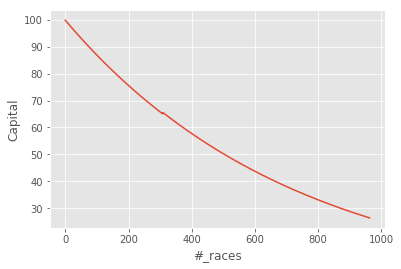

End capital: 26.39, growth rate: -0.14%, exponential growth rate: -0.14%


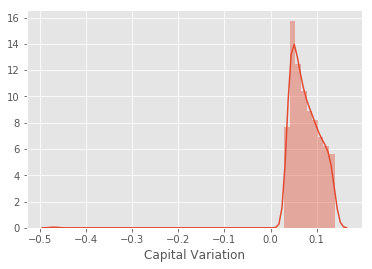

Capital is never null!


In [36]:
sum_proba_races = np.sum(bettings, axis=1)
assert np.all(0<=sum_proba_races) and (np.all(sum_proba_races<=1) or np.all(np.isclose(sum_proba_races, 1.0)))
relative_returns = np.where(y_race==1, bettings*odds*(1-track_take), np.zeros_like(bettings)).sum(axis=1)- np.sum(bettings, axis=1)

capital = np.multiply.accumulate(np.insert(1.0+relative_returns, 0, initial_capital))
data = pd.DataFrame({'Capital Variation':capital[:-1] - capital[1:], "Capital":capital[1:], "Relative returns": relative_returns})
data['#_races']=data.index.to_series()
ax=sns.lineplot(data=data, x="#_races",y="Capital")
plt.show()

exp_growth_rate = np.log(capital[-1]/capital[0])/relative_returns.shape[0]
growth_rate = np.power(capital[-1]/capital[0], 1/relative_returns.shape[0])-1
print(f"End capital: {capital[-1]:.2f}, growth rate: {growth_rate:.2%}, exponential growth rate: {exp_growth_rate:.2%}")
sns.distplot(data['Capital Variation'])
plt.show()
zero_capital_indices =np.argwhere(capital==0.0)
if zero_capital_indices.size==0:
    print('Capital is never null!')
else:
    print(f"No more capital after race n°{zero_capital_indices[0,0]} (index {zero_capital_indices[0,0]-1})")

In [37]:
# Kelly criterion w/ odds
capital_fraction=0.03
bettings = np.array([compute_optimal_betting(race_proba=(1/race_odds)
                                             , race_odds=race_odds ) for race_proba, race_odds, race_expected_return in zip(y_hat,odds, expected_returns)])
bettings =bettings*capital_fraction

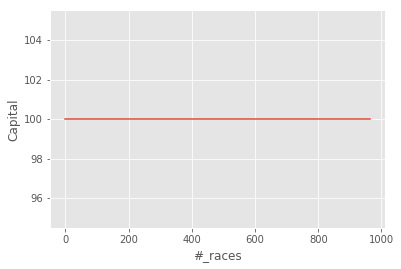

End capital: 100.00, growth rate: 0.00%, exponential growth rate: 0.00%


C:\Users\Mathieu\Anaconda3\envs\deeplearning\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


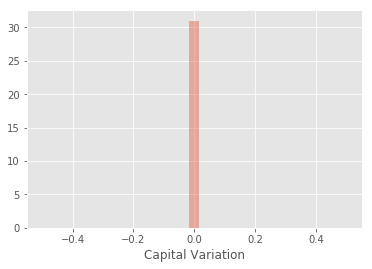

Capital is never null!


In [38]:
sum_proba_races = np.sum(bettings, axis=1)
assert np.all(0<=sum_proba_races) and (np.all(sum_proba_races<=1) or np.all(np.isclose(sum_proba_races, 1.0)))
relative_returns = np.where(y_race==1, bettings*odds*(1-track_take), np.zeros_like(bettings)).sum(axis=1)- np.sum(bettings, axis=1)

capital = np.multiply.accumulate(np.insert(1.0+relative_returns, 0, initial_capital))
data = pd.DataFrame({'Capital Variation':capital[:-1] - capital[1:], "Capital":capital[1:], "Relative returns": relative_returns})
data['#_races']=data.index.to_series()
ax=sns.lineplot(data=data, x="#_races",y="Capital")
plt.show()

exp_growth_rate = np.log(capital[-1]/capital[0])/relative_returns.shape[0]
growth_rate = np.power(capital[-1]/capital[0], 1/relative_returns.shape[0])-1
print(f"End capital: {capital[-1]:.2f}, growth rate: {growth_rate:.2%}, exponential growth rate: {exp_growth_rate:.2%}")
sns.distplot(data['Capital Variation'])
plt.show()
zero_capital_indices =np.argwhere(capital==0.0)
if zero_capital_indices.size==0:
    print('Capital is never null!')
else:
    print(f"No more capital after race n°{zero_capital_indices[0,0]} (index {zero_capital_indices[0,0]-1})")

In [39]:
capital_fraction = 0.01

def compute_scenario(compute_betting):
    np.random.seed(42)
    capital_value = initial_capital
    records=[]
    for x_race, y_race, odds_race in tqdm(import_data.get_dataset_races(source=SOURCE, on_split='val', y_format='rank', remove_nan_odds=True), leave=False):
        odds_race=odds_race*np.sum(1/odds_race) # Rectification to be consistent, HACK since no better data
        betting_race = compute_betting(x_race, odds_race)

        assert 0<=np.sum(betting_race)
        assert np.sum(betting_race)<=1 or np.isclose(np.sum(betting_race), 1.0)

        actual_betting= np.round(betting_race*capital_value,decimals=2)

        capital_value_old=capital_value
        capital_value+= np.where(y_race==1, actual_betting*odds_race*(1-track_take), np.zeros_like(actual_betting)).sum()- np.sum(actual_betting)

        records.append({'Capital Variation': capital_value-capital_value_old, "Capital":capital_value, "Relative Return": (capital_value-capital_value_old)/capital_value_old})


    data = pd.DataFrame.from_records(records)

    data['#_races']=data.index.to_series()
    ax=sns.lineplot(data=data, x="#_races",y="Capital", )
    ax.set(yscale="log")
    plt.show()

    exp_growth_rate = np.log(data['Capital'].iloc[-1]/data['Capital'].iloc[0])/len(data)
    print(f"End capital: {data['Capital'].iloc[-1]:.2f}, exponential growth rate: {exp_growth_rate:.2%}")
    sns.distplot(data['Relative Return'])
    plt.show()

    if (data['Capital']==0).any():
        zero_capital_index = data[data['Capital']==0]['#_races'].iloc[0]
        print(f"No more capital after race n°{zero_capital_index+1} (index {zero_capital_index})")
    else:
        print('Capital is never null!')
    

In [40]:
def race_betting_proportional_positive_return(x_race, odds_race, track_take:float, capital_fraction:float=0.01):
    
    n_horses = x_race.shape[0]
    
    model = utils_model.create_model(n_horses=n_horses, y_format = 'probabilities')
    y_hat_race=model.predict(x=np.expand_dims(x_race, axis=0))[0,:]

    expected_return_race =(y_hat_race*odds_race*(1-track_take))
    positives_returns= np.where(expected_return_race>1, expected_return_race, np.zeros_like(expected_return_race))
    betting_race = positives_returns/np.sum(positives_returns, keepdims=True)
    betting_race[np.isnan(betting_race)]=0
    betting_race=betting_race*capital_fraction
    
    return betting_race

def race_betting_best_expected_return(x_race, odds_race, track_take:float, capital_fraction:float=0.01):
    n_horses = x_race.shape[0]
    
    model = utils_model.create_model(n_horses=n_horses, y_format = 'probabilities')
    y_hat_race=model.predict(x=np.expand_dims(x_race, axis=0))[0,:]

    expected_return_race =(y_hat_race*odds_race*(1-track_take))
    if expected_return_race.max()<=1.0:
        return np.zeros((n_horses,))
    
    betting = expected_return_race==expected_return_race.max()
    assert betting.sum()
    betting =betting/betting.sum()
    betting=betting*capital_fraction
    return betting

def race_bettings_kelly(x_race, odds_race, track_take:float, **kwargs):
    
    n_horses = x_race.shape[0]
    
    model = utils_model.create_model(n_horses=n_horses, y_format = 'probabilities')
    y_hat_race=model.predict(x=np.expand_dims(x_race, axis=0))[0,:]

    expected_return_race =(y_hat_race*odds_race*(1-track_take))
    
    S=[]
    k=1
    R_S =1
    order_index = (-expected_return_race).argsort()

    for kth in order_index:
        if expected_return_race[kth]<R_S:
            break
        S.append(kth)
        R_S = 1 - np.sum(y_hat_race[S])/(1-np.sum(1/(odds_race*(1-track_take))))

    if not S:
        return np.zeros_like(y_hat_race)

    race_f=np.clip((expected_return_race - R_S)/(1-track_take)/odds_race, a_min=0, a_max=None)
    return race_f

def race_betting_proportional_winning_proba(x_race, odds_race, track_take:float, capital_fraction:float=0.01):
    n_horses = x_race.shape[0]
    
    model = utils_model.create_model(n_horses=n_horses, y_format = 'probabilities')
    y_hat_race=model.predict(x=np.expand_dims(x_race, axis=0))[0,:]
    assert np.isclose(y_hat_race.sum(), 1.0)
    betting = y_hat_race*capital_fraction
    
    return betting

def race_betting_best_winning_proba(x_race, odds_race, track_take:float, capital_fraction:float=0.01):
    n_horses = x_race.shape[0]
    
    model = utils_model.create_model(n_horses=n_horses, y_format = 'probabilities')
    y_hat_race=model.predict(x=np.expand_dims(x_race, axis=0))[0,:]
    assert np.isclose(y_hat_race.sum(), 1.0)
    betting = y_hat_race==y_hat_race.max()
    betting = betting/np.sum(betting)
    betting=betting*capital_fraction
    return betting

def race_random_one_horse(x_race, odds_race, track_take:float, capital_fraction:float=0.01):
    n_horses =x_race.shape[0]
    
    betting=np.random.rand(n_horses)
    betting=betting==np.max(betting)
    betting=betting/np.sum(betting)
    betting =betting*capital_fraction
    return betting

def race_random_all_horses(x_race, odds_race, track_take:float, capital_fraction:float=0.01):
    n_horses =x_race.shape[0]
    
    betting=np.ones((n_horses,))/n_horses
    betting =betting*capital_fraction
    return betting

def race_rickiest_horse(x_race, odds_race, track_take:float, capital_fraction:float=0.01):
    n_horses =x_race.shape[0]
    
    betting=odds_race==odds_race.max()
    betting=betting/np.sum(betting)
    betting =betting*capital_fraction
    return betting

def race_least_risky_horse(x_race, odds_race, track_take:float, capital_fraction:float=0.01):
    n_horses =x_race.shape[0]
    
    betting=odds_race==odds_race.min()
    betting=betting/np.sum(betting)
    betting =betting*capital_fraction
    return betting

def race_proportional_odds(x_race, odds_race, track_take:float, capital_fraction:float=0.01):   
    betting=odds_race/np.sum(odds_race)
    betting =betting*capital_fraction
    return betting

def race_proportional_pari_mutual_proba(x_race, odds_race, track_take:float, capital_fraction:float=0.01):
    betting=(1/odds_race)/np.sum((1/odds_race))
    betting =betting*capital_fraction
    return betting

1910it [00:48, 38.99it/s]C:\Users\Mathieu\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


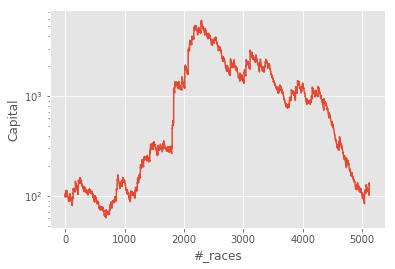

End capital: 127.75, exponential growth rate: 0.00%


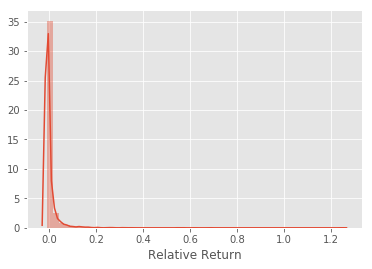

Capital is never null!


In [41]:
capital_fraction=0.01
compute_scenario(functools.partial(race_betting_proportional_positive_return, track_take=track_take, capital_fraction=capital_fraction))

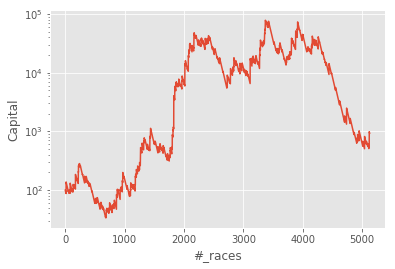

End capital: 924.90, exponential growth rate: 0.04%


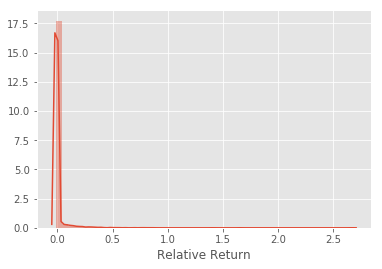

Capital is never null!


In [42]:
capital_fraction=0.01
compute_scenario(functools.partial(race_betting_best_expected_return, track_take=track_take, capital_fraction=capital_fraction))

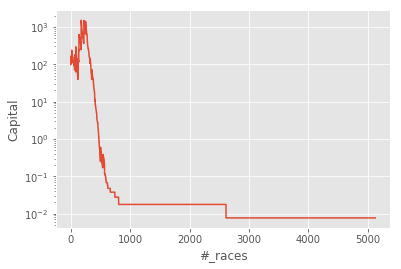

End capital: 0.01, exponential growth rate: -0.18%


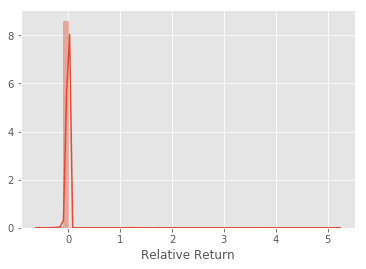

Capital is never null!


In [43]:
compute_scenario(functools.partial(race_bettings_kelly, track_take=track_take))

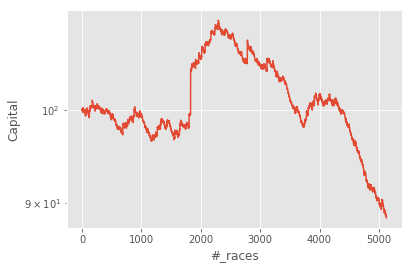

End capital: 88.45, exponential growth rate: -0.00%


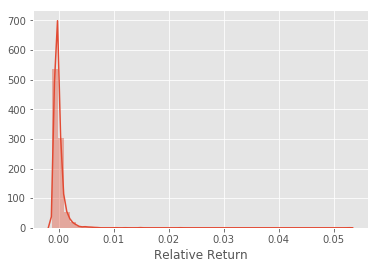

Capital is never null!


In [44]:
capital_fraction=0.001
compute_scenario(functools.partial(race_betting_proportional_winning_proba, track_take=track_take, capital_fraction=capital_fraction))

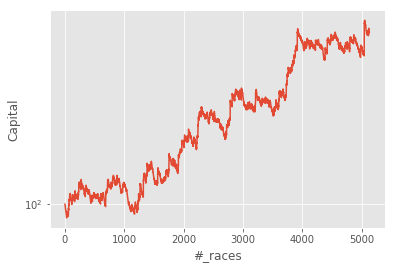

End capital: 143.30, exponential growth rate: 0.01%


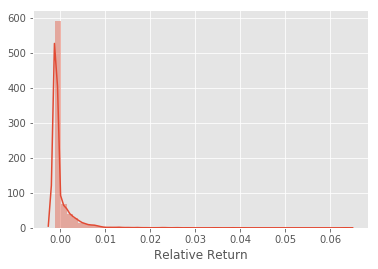

Capital is never null!


In [45]:
capital_fraction=0.001
compute_scenario(functools.partial(race_betting_best_winning_proba, track_take=track_take, capital_fraction=capital_fraction))

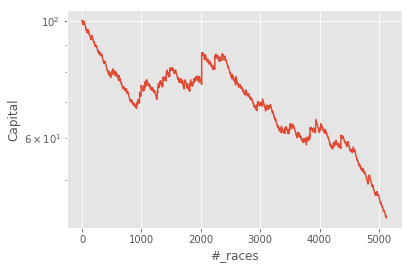

End capital: 42.58, exponential growth rate: -0.02%


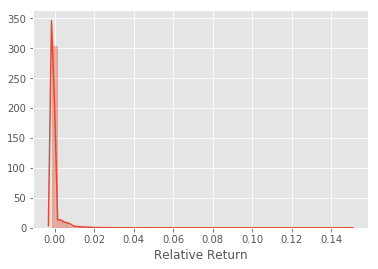

Capital is never null!


In [46]:
capital_fraction=0.001
compute_scenario(functools.partial(race_random_one_horse, track_take=track_take, capital_fraction=capital_fraction))

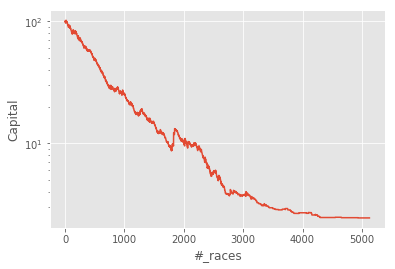

End capital: 2.45, exponential growth rate: -0.07%


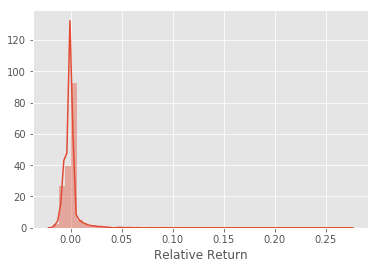

Capital is never null!


In [47]:
capital_fraction=0.01
compute_scenario(functools.partial(race_random_all_horses, track_take=track_take, capital_fraction=capital_fraction))


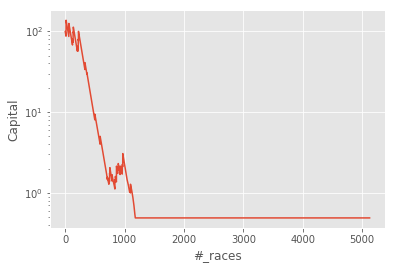

End capital: 0.49, exponential growth rate: -0.10%


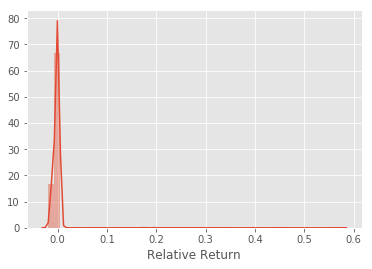

Capital is never null!


In [48]:
capital_fraction=0.01
compute_scenario(functools.partial(race_rickiest_horse, track_take=track_take, capital_fraction=capital_fraction))

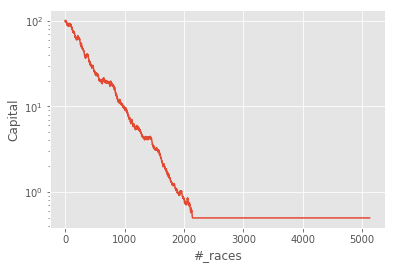

End capital: 0.50, exponential growth rate: -0.10%


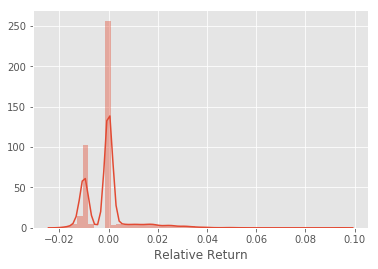

Capital is never null!


In [49]:
capital_fraction=0.01
compute_scenario(functools.partial(race_least_risky_horse, track_take=track_take, capital_fraction=capital_fraction))

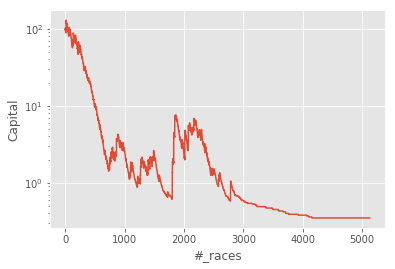

End capital: 0.35, exponential growth rate: -0.11%


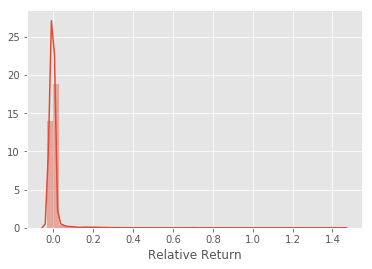

Capital is never null!


In [50]:
capital_fraction=0.02
compute_scenario(functools.partial(race_proportional_odds, track_take=track_take, capital_fraction=capital_fraction))

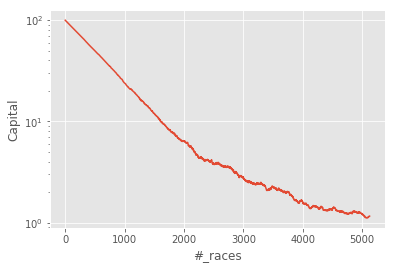

End capital: 1.16, exponential growth rate: -0.09%


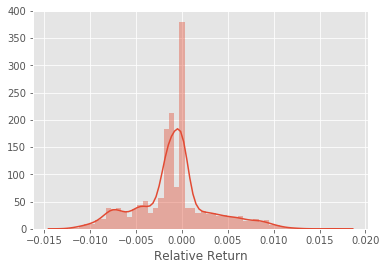

Capital is never null!


In [51]:
capital_fraction=0.01
compute_scenario(functools.partial(race_proportional_pari_mutual_proba, track_take=track_take, capital_fraction=capital_fraction))